In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit

from lightgbm import LGBMRegressor, early_stopping
from shaphypetune import BoostRFE, BoostBoruta

import warnings
warnings.simplefilter('ignore')

In [3]:
### UTILITY FUNCTION TO GENERATE SYNTHETIC DATA ###

def gen_sinusoidal(timesteps, amp, freq, noise, timedependecy=True):
    
    X = np.arange(timesteps)
    if timedependecy:
        e = np.random.normal(0,np.linspace(0,noise, timesteps))
    else:
        e = np.random.normal(0,noise, timesteps)
    y = amp*np.sin(X*(2*np.pi/freq))+e
    
    return y

In [4]:
### CREATE SYNTHETIC DATA ###

np.random.seed(42)

timesteps = 8000
seas1 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24, noise=9)
seas2 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24*7, noise=9)
seas3 = gen_sinusoidal(timesteps=timesteps, amp=5, freq=12*7, noise=9)
random = np.random.normal(0,1, (timesteps,15)) # uniform(-10,10, (timesteps,15))

X = pd.DataFrame({
    'sin1': seas1,
    'sin2': seas2,
    'sin3': seas3
})

for i in range(random.shape[1]):
    X[f'random{i}'] = random[:,i]
    
seas1 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24, noise=0, timedependecy=False)
seas2 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24*7, noise=0, timedependecy=False)
seas3 = gen_sinusoidal(timesteps=timesteps, amp=5, freq=12*7, noise=0, timedependecy=False)
Y = pd.Series(seas1 + seas2 + seas3, index=X.index, name='target')

X.shape, Y.shape

((8000, 18), (8000,))

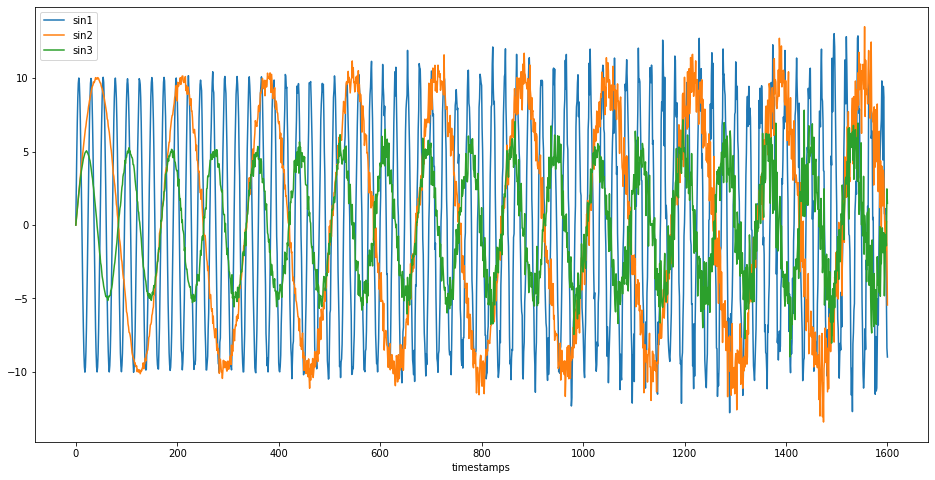

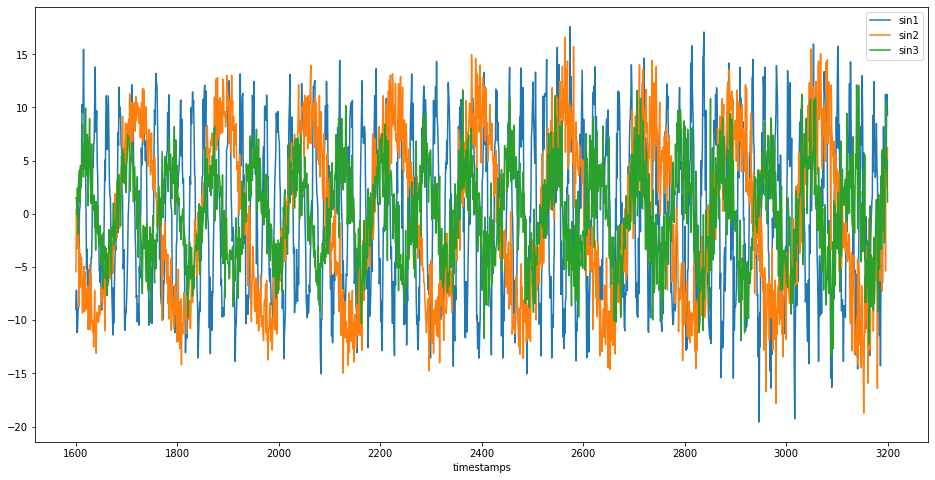

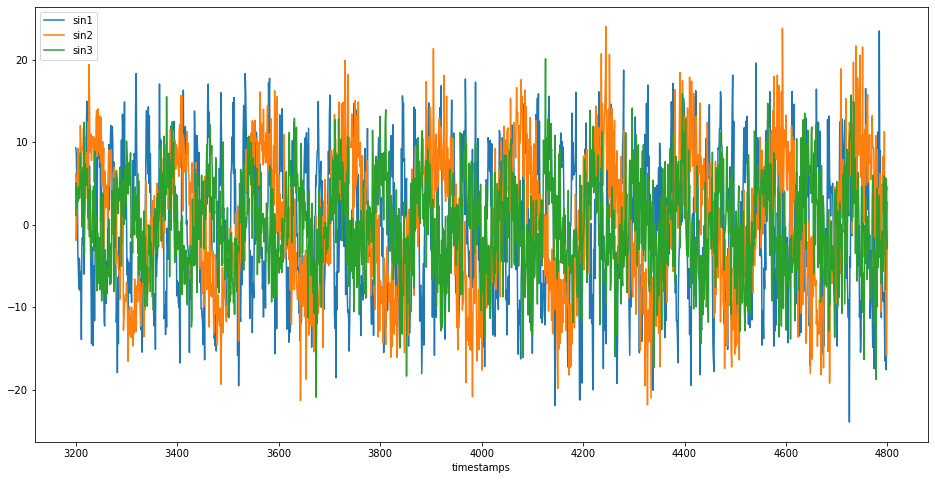

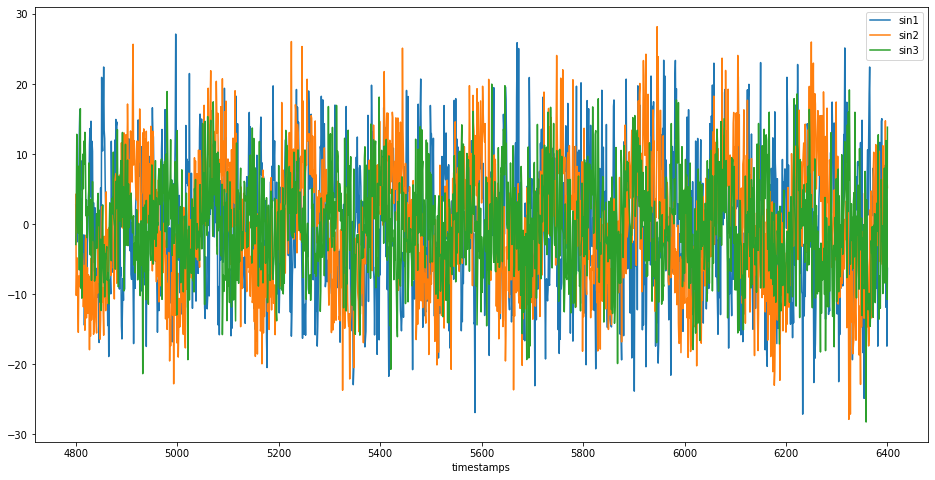

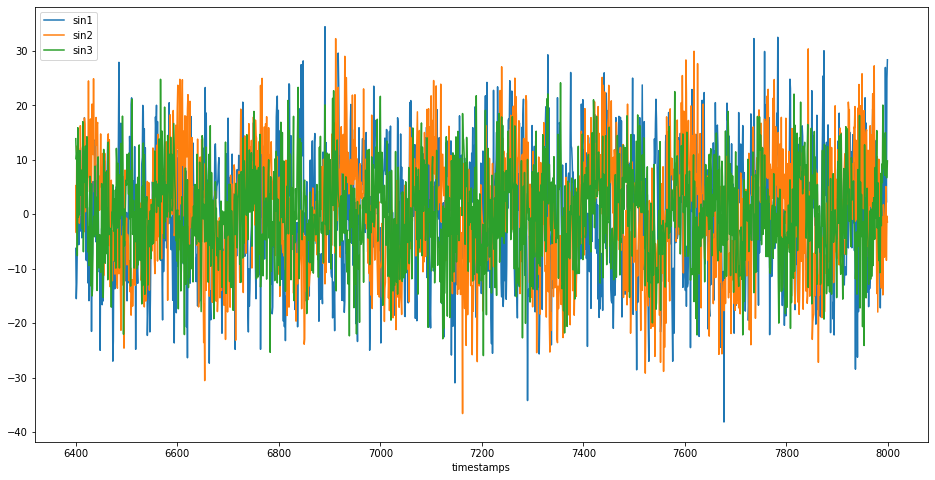

In [5]:
### PLOT SINUSOIDALS OVER TIME ###

chunck_size = len(X)//5

for start,end in zip(range(0, len(X), chunck_size), range(chunck_size, len(X)+chunck_size, chunck_size)):

    X.loc[start:end, X.columns.str.contains('sin')].plot(figsize=(16,8))
    plt.xlabel('timestamps')
    plt.show()

Text(0, 0.5, 'correlation')

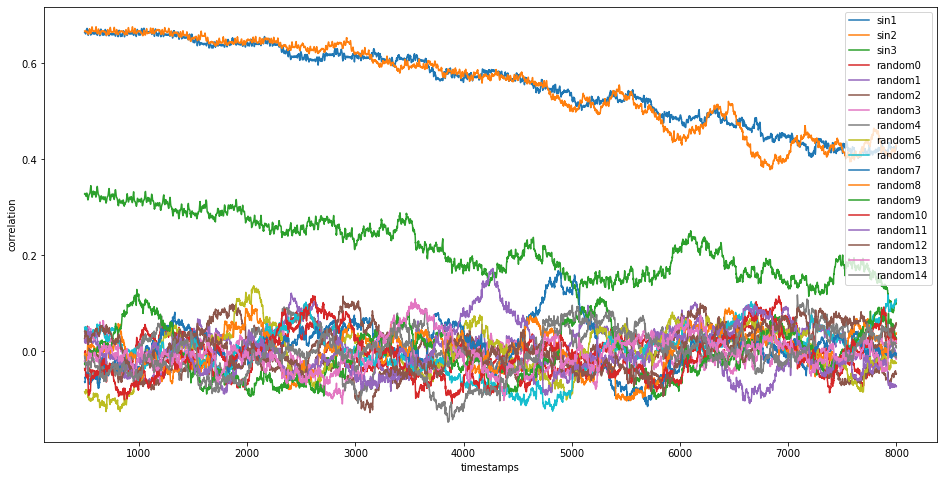

In [6]:
### PLOT ROLLING CORRELATIONS OVER TIME BETWEEN FEATURES AND TARGET ###

df_corr = pd.concat([X, pd.DataFrame(Y)], axis=1).rolling(500).corr()
df_corr = df_corr.loc[df_corr.index.get_level_values(1) == 'target'].drop(columns=['target'])
df_corr = df_corr.reset_index(drop=True)

df_corr.plot(figsize=(16,8), legend=True)
plt.xlabel('timestamps'); plt.ylabel('correlation')

In [7]:
### DEFINE EXPERIMENT UTILITIES ###

CV = TimeSeriesSplit(n_splits=15, test_size=24*7*3)
lgbm = LGBMRegressor(n_estimators=200, learning_rate=0.5, random_state=42, n_jobs=-1)

In [8]:
### RUN BORUTA SHAP ###

select_trials = {}

for i,(id_train,id_test) in enumerate(CV.split(X)):
    
    print(f'--- FITTING SPLIT {i+1} ---')
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X.iloc[id_train], Y[id_train], 
        test_size=24*7, shuffle=False,
    )
    
    model = BoostBoruta(
        lgbm,
        importance_type='shap_importances', train_importance=False
    )
    model.fit(
        X_train, y_train, 
        eval_set=[(X_valid, y_valid)], 
        callbacks=[early_stopping(11, verbose=False)]
    )
    
    select_trials[i+1] = model.support_

--- FITTING SPLIT 1 ---
--- FITTING SPLIT 2 ---
--- FITTING SPLIT 3 ---
--- FITTING SPLIT 4 ---
--- FITTING SPLIT 5 ---
--- FITTING SPLIT 6 ---
--- FITTING SPLIT 7 ---
--- FITTING SPLIT 8 ---
--- FITTING SPLIT 9 ---
--- FITTING SPLIT 10 ---
--- FITTING SPLIT 11 ---
--- FITTING SPLIT 12 ---
--- FITTING SPLIT 13 ---
--- FITTING SPLIT 14 ---
--- FITTING SPLIT 15 ---


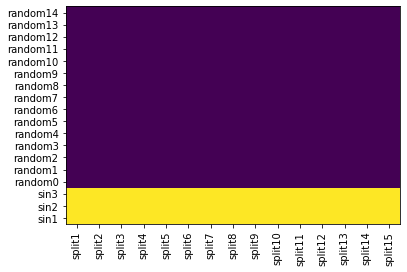

In [9]:
### PLOT BORUTA SHAP SELECTION RESULTS OVER TEMPORAL SPLITS ###

plt.pcolor(pd.DataFrame(select_trials, index=X.columns))
plt.yticks(np.arange(0.5, len(X.columns), 1), X.columns)
plt.xticks(np.arange(0.5, CV.n_splits, 1), [f"split{s}" for s in range(1,CV.n_splits+1)], rotation=90)
plt.title(""); plt.show()

In [10]:
### RUN RFE SHAP ###

select_trials = {}

for i,(id_train,id_test) in enumerate(CV.split(X)):
    
    print(f'--- FITTING SPLIT {i+1} ---')
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X.iloc[id_train], Y[id_train], 
        test_size=24*7, shuffle=False,
    )
    
    model = BoostRFE(
        lgbm, 
        importance_type='shap_importances', train_importance=False
    )
    model.fit(
        X_train, y_train, 
        eval_set=[(X_valid, y_valid)], 
        callbacks=[early_stopping(11, verbose=False)]
    )
    
    select_trials[i+1] = model.support_

--- FITTING SPLIT 1 ---
--- FITTING SPLIT 2 ---
--- FITTING SPLIT 3 ---
--- FITTING SPLIT 4 ---
--- FITTING SPLIT 5 ---
--- FITTING SPLIT 6 ---
--- FITTING SPLIT 7 ---
--- FITTING SPLIT 8 ---
--- FITTING SPLIT 9 ---
--- FITTING SPLIT 10 ---
--- FITTING SPLIT 11 ---
--- FITTING SPLIT 12 ---
--- FITTING SPLIT 13 ---
--- FITTING SPLIT 14 ---
--- FITTING SPLIT 15 ---


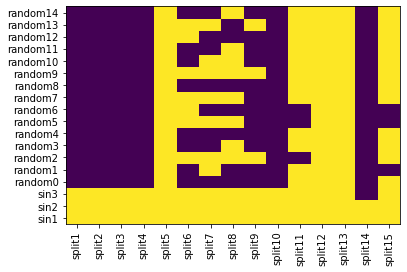

In [11]:
### PLOT RFE SHAP SELECTION RESULTS OVER TEMPORAL SPLITS ###

plt.pcolor(pd.DataFrame(select_trials, index=X.columns))
plt.yticks(np.arange(0.5, len(X.columns), 1), X.columns)
plt.xticks(np.arange(0.5, CV.n_splits, 1), [f"split{s}" for s in range(1,CV.n_splits+1)], rotation=90)
plt.title(""); plt.show()